# Cycle GAN

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import utils
from torch.utils.data import DataLoader
import tqdm as tqdm
import matplotlib.pyplot as plt
import numpy as np

/home/johann/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Discriminator

In [2]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, out_channels=1):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv1d(in_channels, out_channels=1, kernel_size=4, stride=2, padding=0),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(1, 1, 4, 2, 0),
            nn.InstanceNorm1d(1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(1, 1, 4, 2, 0),
            nn.InstanceNorm1d(1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(1, 1, 4, 2, 0),
            nn.InstanceNorm1d(1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(1, 1, 4, 2, 0),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)

# pass 1d tensor through the discriminator and return the output
#LVP_tiny = LVP[0:100]
#LVP_tiny = torch.tensor(LVP_tiny).double()
#LVP_tiny = LVP_tiny.reshape(1, 1, 100)
#LVP_tiny = LVP_tiny.float()
#print(LVP_tiny)
disc = Discriminator(1)
#y = disc(LVP_tiny)
print(disc)


Discriminator(
  (disc): Sequential(
    (0): Conv1d(1, 1, kernel_size=(4,), stride=(2,))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv1d(1, 1, kernel_size=(4,), stride=(2,))
    (3): InstanceNorm1d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv1d(1, 1, kernel_size=(4,), stride=(2,))
    (6): InstanceNorm1d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv1d(1, 1, kernel_size=(4,), stride=(2,))
    (9): InstanceNorm1d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv1d(1, 1, kernel_size=(4,), stride=(2,))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Sigmoid()
  )
)


### Generator

In [3]:
#residual block
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(channels, channels, 3, 1, 1),
            nn.InstanceNorm1d(channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(channels, channels, 3, 1, 1),
            nn.InstanceNorm1d(channels),
                )

    def forward(self, x):
        return x + self.block(x)

# Generator class with 2 Residual blocks
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Conv1d(in_channels, out_channels=64, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 128, 3, 2, 1),
            nn.InstanceNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 256, 3, 2, 1),
            nn.InstanceNorm1d(256),
            nn.ReLU(inplace=True),
            ResidualBlock(256),
            ResidualBlock(256),
            nn.ConvTranspose1d(256, 128, 3, 2, 1, 1),
            nn.InstanceNorm1d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(128, 64, 3, 2, 1, 1),
            nn.InstanceNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, out_channels, 7, 1, 3),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.gen(x)

# pass 1d tensor through the block and return the output
gen = Generator(1, 1)
#y = gen( LVP_tiny)
#print("Output of Generator: ", y.shape, '\n', y, '\n')
print(gen)

Generator(
  (gen): Sequential(
    (0): Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): InstanceNorm1d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
    (4): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU(inplace=True)
    (6): Conv1d(128, 256, kernel_size=(3,), stride=(2,), padding=(1,))
    (7): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): ReLU(inplace=True)
    (9): ResidualBlock(
      (block): Sequential(
        (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
        (3): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (4): InstanceNorm1d(256, eps=1e-05, momentum=0.1, a

## Dataset
### Load data from csv

In [4]:
# read csv file semi-colon separated
df_1 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_11_1_1_1_1_1_1_2.csv", sep=";")
df_2 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_11_1_1_1_1_1_3_2.csv", sep=";")
df_3 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_11_1_1_1_1_1_10_2.csv", sep=";")
df_4 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_11_1_2_1_1_1_1_2.csv", sep=";")
df_5 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_11_1_2_1_1_1_3_2.csv", sep=";")
df_6 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_11_1_2_1_1_1_10_2.csv", sep=";")
df_7 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_11_1_3_1_1_1_1_2.csv", sep=";")
df_8 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_11_1_3_1_1_1_3_2.csv", sep=";")
df_9 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_11_1_3_1_1_1_10_2.csv", sep=";")
df_10 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_11_1_4_1_1_1_1_2.csv", sep=";")
df_11 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_11_1_4_1_1_1_3_2.csv", sep=";")
df_12 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_13_1_1_1_1_1_1_2.csv", sep=";")
df_13 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_13_1_1_1_1_1_3_2.csv", sep=";")
df_14 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_13_1_1_1_1_1_10_2.csv", sep=";")
df_15 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_13_1_2_1_1_1_1_2.csv", sep=";")
df_16 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_13_1_2_1_1_1_3_2.csv", sep=";")
df_17 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_13_1_3_1_1_1_1_2.csv", sep=";")
df_18 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_13_1_3_1_1_1_3_2.csv", sep=";")
df_19 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_13_1_4_1_1_1_1_2.csv", sep=";")
df_20 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_13_1_5_1_1_1_1_2.csv", sep=";")
df_21 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_16_1_1_1_1_1_1_2.csv", sep=";")
df_22 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_16_1_1_1_1_1_3_2.csv", sep=";")
df_23 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_16_1_1_1_1_1_10_2.csv", sep=";")
df_24 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_16_1_2_1_1_1_1_2.csv", sep=";")
df_25 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_16_1_2_1_1_1_3_2.csv", sep=";")
df_26 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_16_1_3_1_1_1_1_2.csv", sep=";")
df_27 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_16_1_3_1_1_1_3_2.csv", sep=";")
df_28 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_16_2_1_1_1_1_1_2.csv", sep=";")
df_29 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_16_2_1_1_1_1_3_2.csv", sep=";")
df_30 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_16_2_1_1_1_1_10_2.csv", sep=";")
df_31 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_16_2_2_1_1_1_1_2.csv", sep=";")
df_32 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_16_2_2_1_1_1_3_2.csv", sep=";")
df_33 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_16_2_3_1_1_1_1_2.csv", sep=";")
df_34 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_16_2_3_1_1_1_3_2.csv", sep=";")
df_35 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_17_1_1_1_1_1_1_2.csv", sep=";")
df_36 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_17_1_1_1_1_1_3_2.csv", sep=";")
df_37 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_17_1_1_1_1_1_10_2.csv", sep=";")
df_38 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_17_1_2_1_1_1_1_2.csv", sep=";")
df_39 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_17_1_2_1_1_1_3_2.csv", sep=";")
df_40 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_17_1_3_1_1_1_1_2.csv", sep=";")
df_41 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_17_1_3_1_1_1_3_2.csv", sep=";")
df_42 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_17_1_4_1_1_1_3_2.csv", sep=";")
df_43 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_17_2_1_1_1_1_3_2.csv", sep=";")
df_44 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_17_2_2_1_1_1_3_2.csv", sep=";")
df_45 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_17_2_3_1_1_1_3_2.csv", sep=";")
df_46 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_19_1_1_1_1_1_1_2.csv", sep=";")
df_47 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_19_1_1_1_1_1_3_2.csv", sep=";")
df_48 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_19_1_2_1_1_1_1_2.csv", sep=";")
df_49 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_19_1_2_1_1_1_3_2.csv", sep=";")
df_50 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_19_1_3_1_1_1_1_2.csv", sep=";")
df_51 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_19_1_3_1_1_1_3_2.csv", sep=";")
df_52 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_20_1_1_1_1_1_1_2.csv", sep=";")
df_53 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_20_1_1_1_1_1_3_2.csv", sep=";")
df_54 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_20_1_1_1_1_1_10_2.csv", sep=";")
df_55 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_20_1_2_1_1_1_1_2.csv", sep=";")
df_56 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_20_1_2_1_1_1_3_2.csv", sep=";")
df_57 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_20_1_3_1_1_1_1_2.csv", sep=";")
df_58 = pd.read_csv("/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/intervention_20_1_3_1_1_1_3_2.csv", sep=";")

In [5]:
# concatenate df_1 to df_58 into one dataframe
df = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9, df_10, df_11, df_12, df_13, df_14, df_15, df_16,
                df_17, df_18, df_19, df_20, df_21, df_22, df_23, df_24, df_25, df_26, df_27, df_28, df_29, df_30,
                df_31, df_32, df_33, df_34, df_35, df_36, df_37, df_38, df_39, df_40, df_41, df_42, df_43, df_44,
                df_45, df_46, df_47, df_48, df_49, df_50, df_51, df_52, df_53, df_54, df_55, df_56, df_57, df_58], ignore_index=True)

print(df.shape)

# access columns by name (e.g. df['LVP']) or by index (e.g. df.iloc[:, 0])

# drop columns that are not needed (all except 'LVP', 'AoP', 'AoQ', 'intervention')
df = df.drop(columns=['Time', 'LVtot_kalibriert', 'RVtot_kalibriert', 'RVP', 'PaP', 'PaQ',
                        'VADspeed', 'VadQ', 'VADcurrent', 'Looperkennung', 'Phasenzuordnung', 'Extrasystolen',
                        'Ansaugphase', 'ECGcond', 'ECG', 'LVtot', 'RVtot', 'LVV1', 'LVV2', 'LVV3', 'LVV4', 'LVV5',
                        'RVV1', 'RVV2', 'RVV3', 'RVV4', 'RVV5', 'Versuchsdatum', 'animal', 'rep_an', 'rep_sect',
                        'contractility', 'preload', 'afterload', 'controller'])

# drop rows that contain NaN values
df = df.dropna()

print(df.shape)

(8120300, 39)
(8120300, 4)


In [6]:
from sklearn.model_selection import train_test_split

# select only rows where 'intervention' is 1
df = df[df['intervention'] == 1]
print(df.shape) 

# split data into training and test set
df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False, stratify = None)

# remove rows so that modulo 100 = 0
#df_train = df_train.iloc[:-(len(df_train) % 100), :]
#df_test = df_test.iloc[:-(len(df_test) % 100), :]

#print(df_train.shape, df_test.shape)

(2159400, 4)


In [7]:
df_test

,LVP,AoP,AoQ,intervention
7025890,58.48750,47.58520,5.341380,1
7025891,58.59651,47.75435,5.400735,1
7025892,58.70324,47.92556,5.453197,1
7025893,58.80915,48.10119,5.498950,1
7025894,58.90917,48.27407,5.539687,1
...,...,...,...,...
8054495,60.71935,57.98892,4.732170,1
8054496,60.50231,57.96017,4.647769,1
8054497,60.27828,57.92654,4.567691,1
8054498,60.03920,57.88646,4.491730,1


### Subsample the date by a factor of 0.1 to remove noise from the data

In [8]:
# subsample data by a factor of 10
df_train = df_train.sample(frac=0.1, random_state=1)
df_test = df_test.sample(frac=0.1, random_state=1)

# remove rows so that modulo 100 = 0
df_train = df_train.iloc[:-(len(df_train) % 100), :]
df_test = df_test.iloc[:-(len(df_test) % 100), :]

print(df_train.shape, df_test.shape)

(183500, 4) (32300, 4)


### Run with sinus and cosinus and/or spike curve data

In [9]:
#generate sinusoidal signal with 100000 samples
#x = np.linspace(0, 100, 10000)
#sin = np.sin(x)

# plot data
#plt.plot(x, sin)

# generate cosine signal with 100000 samples
#x = np.linspace(0, 100, 10000)
#cos = np.cos(x)

# plot data
#plt.plot(x, cos)

#create a dataframe with the sine and cosine signals
#df = pd.DataFrame({'sin': sin, 'cos': cos})
#print(df.shape)

In [10]:
# generate sine signal with 100000 samples
#x = np.linspace(0, 200, 10000)
#sin = np.sin(x)

# plot data
#plt.plot(x, sin)

# generate cosine signal with 100000 samples
#x = np.linspace(0, 200, 10000)
#cos = np.cos(x)

# plot data
#plt.plot(x, cos)

#create a dataframe with the sine and cosine signals
#df_test = pd.DataFrame({'sin': sin, 'cos': cos})

In [11]:
class SignalDataset(Dataset):
    def __init__(self, signal_A, signal_B, df):
        self.df = df
        self.signal_A = self.df[signal_A]
        self.signal_B = self.df[signal_B]

        # creating tensor from df 
        self.tensor_A = torch.tensor(self.df[signal_A].values)
        self.tensor_B = torch.tensor(self.df[signal_B].values)

        # split tensor into tensors of size 100
        self.tensor_A = self.tensor_A.split(100)
        self.tensor_B = self.tensor_B.split(100)

        self.tensor_A = torch.stack(self.tensor_A).unsqueeze(1) #solves batch size problem
        self.tensor_B = torch.stack(self.tensor_B).unsqueeze(1) #solves batch size problem
   

    def __len__(self):
        # signal_A and signal_B should have the same length
        return len(self.tensor_A)

    def __getitem__(self, index):
        # return the signal at the given index
        return self.tensor_A[index], self.tensor_B[index]

### Train model

In [12]:
# config

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
LAMBDA_IDENTITY = 0.0
LAMBDA_CYCLE = 10
NUM_WORKERS = 4
NUM_EPOCHS =101
LOAD_MODEL = False
SAVE_MODEL = False
SIG_A = "AoP"
SIG_B = "AoQ"
CHECKPOINT_GEN_A2B = "Checkpoints/Generated_data/gen_{}.pth.tar".format(SIG_B)
CHECKPOINT_GEN_B2A = "Checkpoints/Generated_data/gen_{}.pth.tar".format(SIG_A)
CHECKPOINT_DISC_A =  "Checkpoints/Generated_data/disc{}.pth.tar".format(SIG_A)
CHECKPOINT_DISC_B =  "Checkpoints/Generated_data/disc{}.pth.tar".format(SIG_B)


Shape of train df:  (183500, 4) 

Shape of test dataframe:  (32300, 4)
MSE G_A2B: 6.6865, MSE G_B2A: 2017.1619


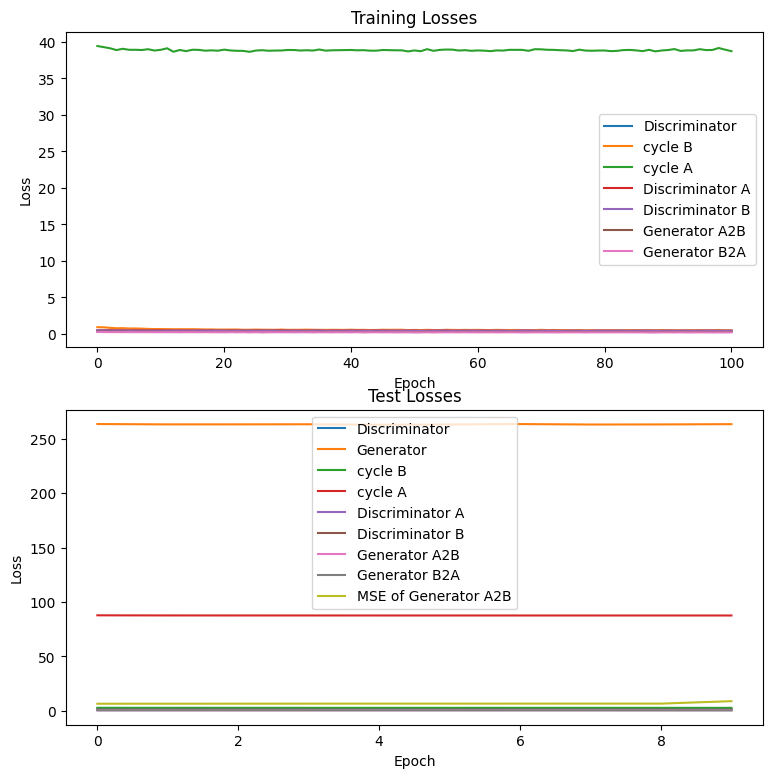

In [13]:
def main():
    # initialize generator and discriminator
    gen_A2B = Generator(in_channels=1, out_channels=1).to("cuda")
    gen_B2A = Generator(in_channels=1, out_channels=1).to("cuda")
    disc_A = Discriminator(in_channels=1).to("cuda")
    disc_B = Discriminator(in_channels=1).to("cuda")

    # optimizers for discriminator and generator 
    opt_disc = torch.optim.Adam(
        list(disc_A.parameters()) + list(disc_B.parameters()), 
        lr=LEARNING_RATE, 
        betas=(0.5, 0.999) 
    )
    opt_gen = torch.optim.Adam(
        list(gen_A2B.parameters()) + list(gen_B2A.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999)
    )

    l1 = nn.L1Loss() # L1 loss for cycle consistency and identity loss
    mse = nn.MSELoss() # MSE loss for adversarial loss

    if LOAD_MODEL:
        utils.load_checkpoint(
            CHECKPOINT_GEN_B2A, gen_A2B, opt_gen, LEARNING_RATE,
        )
        utils.load_checkpoint(
            CHECKPOINT_GEN_A2B, gen_B2A, opt_gen, LEARNING_RATE,
        )
        utils.load_checkpoint(
            CHECKPOINT_DISC_A, disc_A, opt_disc, LEARNING_RATE,
        )
        utils.load_checkpoint(
            CHECKPOINT_DISC_B, disc_B, opt_disc, LEARNING_RATE,
        )

    # train and test data
    print('Shape of train df: ', df_train.shape, '\n') # df_train is a global variable that contains the data
    print('Shape of test dataframe: ', df_test.shape)

    # create datasets with class SignalDataset
    dataset = SignalDataset(signal_A=SIG_A, signal_B=SIG_B, df=df_train)
    test_dataset = SignalDataset(signal_A=SIG_A, signal_B=SIG_B, df=df_test)
    # Data loader to generate fake signals with batch size = 1
    gen_dataset = SignalDataset(signal_A=SIG_A, signal_B=SIG_B, df=df_test)
    
    # Data loader
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True,)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True,)
    gen_loader = DataLoader(gen_dataset, batch_size=1, shuffle=False, pin_memory=True,)

    # run in float16
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    # stote losses in dictionaries
    train_losses = {
        'cycle_B_loss': [],
        'cycle_A_loss': [],
        'identity_A_loss': [],
        'identity_B_loss': [],
        'disc_A_loss': [],
        'disc_B_loss': [],
        'gen_A2B_loss': [],
        'gen_B2A_loss': [],
        'd_loss': [],
        'g_loss': [],
    }

    test_losses = {
        'cycle_B_loss': [],
        'cycle_A_loss': [],
        'disc_A_loss': [],
        'disc_B_loss': [],
        'gen_A2B_loss': [],
        'gen_B2A_loss': [],
        'd_loss': [],
        'g_loss': [],
        'mse_G_A2B': [],
        'mse_G_B2A': [],
    }

    # --------------------------------- #
    # ------------ Training ----------- #
    # --------------------------------- #

    # training loop
    for epoch in range(NUM_EPOCHS):

        for sig_A, sig_B in loader:
            # convert to float16
            sig_A = sig_A.float() # neccessary to prevent error: "Input type (torch.cuda.DoubleTensor) 
            sig_B = sig_B.float() # and weight type (torch.cuda.HalfTensor) should be the same"
        
            # move to GPU
            sig_A = sig_A.to(DEVICE)
            sig_B = sig_B.to(DEVICE)

            # train discriminators
            with torch.cuda.amp.autocast(): # necessary for float16

                fake_B = gen_A2B(sig_A) # generate fake signal B
                d_B_real = disc_B(sig_B) # output of discriminator B for real signal B
                d_B_fake = disc_B(fake_B.detach()) # output of discriminator B for fake signal B (detached from generator)

                # Loss between dicriminator (with real signal) output and 1 - The discriminator should output 1 for real signals
                d_B_real_loss = mse(d_B_real, torch.ones_like(d_B_real))  
                # Loss between dicriminator (with fake signal) output and 0 - The discriminator should output 0 for fake signals
                d_B_fake_loss = mse(d_B_fake, torch.zeros_like(d_B_fake)) 
                # Total loss for discriminator B
                d_B_loss = d_B_real_loss + d_B_fake_loss

                fake_A = gen_B2A(sig_B)
                d_A_real = disc_A(sig_A)
                d_A_fake = disc_B(fake_A.detach()) 
                d_A_real_loss = mse(d_A_real, torch.ones_like(d_A_real)) 
                d_A_fake_loss = mse(d_A_fake, torch.zeros_like(d_A_fake))  
                d_A_loss = d_A_real_loss + d_A_fake_loss

                # Total loss for discriminator A
                d_loss = (d_A_loss + d_B_loss) / 2 # why average? Mentioned in cycle GAN paper

            # exit amp.auto_cast() context manager and backpropagate 
            opt_disc.zero_grad()   
            d_scaler.scale(d_loss).backward() 
            d_scaler.step(opt_disc)
            d_scaler.update()

            # train generators
            with torch.cuda.amp.autocast():

                # ----- adversarial loss for both generators ----- #
                d_A_fake = disc_A(fake_A) # disc_A should output 0 for fake signal A
                d_B_fake = disc_B(fake_B) # disc_B should output 0 for fake signal B
                # loss between discriminator output and 0 - The discriminator should output 0 for fake signals
                g_A_loss = mse(d_A_fake, torch.zeros_like(d_A_fake)) # was ones_like before  
                g_B_loss = mse(d_B_fake, torch.zeros_like(d_B_fake)) # was ones_like before

                # ----- cycle consistency loss ----- #
                cycle_B = gen_A2B(fake_A) # fake_A = gen_B2A(sig_B)
                cycle_A = gen_B2A(fake_B) # fake_B = gen_A2B(sig_A)
                cycle_B_loss = l1(sig_B, cycle_B)  # l1 loss: Mean absolute error between each element in the input x and target y.
                cycle_A_loss = l1(sig_A, cycle_A)

                # ----- identity loss ----- #
                id_B = gen_A2B(sig_B) 
                id_A = gen_B2A(sig_A)
                id_B_loss = l1(sig_B, id_B)
                id_A_loss = l1(sig_A, id_A)

                # put it all together
                g_loss = (
                    g_A_loss +
                    g_B_loss +
                    cycle_B_loss * LAMBDA_CYCLE +
                    cycle_A_loss * LAMBDA_CYCLE +
                    id_B_loss * LAMBDA_IDENTITY +  # LAMBDA_IDENTITY = 0.0 -> no identity loss 
                    id_A_loss * LAMBDA_IDENTITY    # we could remove it to increase training speed
                )

            opt_gen.zero_grad()
            g_scaler.scale(g_loss).backward()
            g_scaler.step(opt_gen)
            g_scaler.update()
        
        # print losses
        # print('Cycle B loss: {:.4f}, Cycle A loss: {:.4f}'.format(cycle_B_loss.item(), cycle_A_loss.item()))
        # print('\nEpoch [{}/{}], Loss D: {:.4f}, loss G: {:.4f}'.format(epoch+1, NUM_EPOCHS, d_loss.item(), g_loss.item()))
        
        # save losses
        train_losses['d_loss'].append(d_loss.item())
        train_losses['g_loss'].append(g_loss.item())
        train_losses['cycle_B_loss'].append(cycle_B_loss.item())
        train_losses['cycle_A_loss'].append(cycle_A_loss.item())
        train_losses['identity_A_loss'].append(id_A_loss.item())
        train_losses['identity_B_loss'].append(id_B_loss.item())
        train_losses['disc_A_loss'].append(d_A_loss.item())
        train_losses['disc_B_loss'].append(d_B_loss.item())
        train_losses['gen_A2B_loss'].append(g_A_loss.item())
        train_losses['gen_B2A_loss'].append(g_B_loss.item())

        # ------------------------ #
        # ------ Validation ------ #
        # ------------------------ #

        #  validation every 10 epochs
        if (epoch+1) % 10 == 0:
            # set models to evaluation mode
            disc_A.eval()  # set discriminator to evaluation mode
            disc_B.eval()  # turns off Dropouts Layers, BatchNorm Layers etc
            gen_A2B.eval()
            gen_B2A.eval()

            with torch.no_grad():
                # reset losses
                mse_G_A2B = 0
                mse_G_B2A = 0
                g_A_loss = 0
                g_B_loss = 0
                cycle_B_loss = 0
                cycle_A_loss = 0
                d_A_loss = 0
                d_B_loss = 0
                g_loss = 0
                d_loss = 0

                #  ------------------------------------- #   
                #  ------- Generate fake signals ------- #
                #  ------------------------------------- #
                
                # generate fake signals every 100 epochs
                # Generation is in the validation loop because this was easier to implement

                if (epoch+1) % 100 == 0:
                    generate = True

                    for sig_A, sig_B in gen_loader:
                        if generate == True:
                            generate = False
                            # convert to float16
                            sig_A = sig_A.float()
                            sig_B = sig_B.float()

                            # move to GPU
                            sig_A = sig_A.to(DEVICE)
                            sig_B = sig_B.to(DEVICE)

                            fake_B = gen_A2B(sig_A)
                            fake_A = gen_B2A(sig_B)

                            # print(fake_B.shape) # torch.Size([1, 1, 100])
                            # reshape to 1D
                            fake_B = fake_B.reshape(-1)
                            fake_A = fake_A.reshape(-1)
                            sig_A = sig_A.reshape(-1)
                            sig_B = sig_B.reshape(-1)

                            # calculate mse loss of fake signals and real signals
                            mse_G_A2B = mse(fake_B, sig_B)
                            mse_G_B2A = mse(fake_A, sig_A)
                            print('MSE G_A2B: {:.4f}, MSE G_B2A: {:.4f}'.format(mse_G_A2B.item(), mse_G_B2A.item()))
                            

                            #print(fake_B.shape) # torch.Size([100])
                            # save generated signals as csv in one file
                            df = pd.DataFrame({'sig_A': sig_A.cpu().numpy(), 'fake_A': fake_A.cpu().numpy(), 
                                         'sig_B': sig_B.cpu().numpy(), 'fake_B': fake_B.cpu().numpy()})
                            df.to_csv('generated_signals.csv', index=True)

                #  ------------------------------------- #
                #  ---------- Generation over ---------- #
                #  ------------------------------------- #

                for sig_A, sig_B in test_loader:
                    # convert to float16
                    sig_A = sig_A.float()
                    sig_B = sig_B.float()

                    # move to GPU
                    sig_A = sig_A.to(DEVICE)
                    sig_B = sig_B.to(DEVICE)

                    fake_B = gen_A2B(sig_A)
                    fake_A = gen_B2A(sig_B)

                    #print(fake_B.shape)
                
                    # calculate mse loss of fake signals and real signals
                    mse_A2B = mse(sig_B, fake_B)
                    mse_B2A = mse(sig_A, fake_A)
                    mse_G_A2B += mse_A2B
                    mse_G_B2A += mse_B2A

                    # calculate Generator loss
                    g_A_loss = mse(disc_B(fake_B), torch.ones_like(disc_B(fake_B)))
                    g_B_loss = mse(disc_A(fake_A), torch.ones_like(disc_A(fake_A)))
                    g_A_loss += g_A_loss
                    g_B_loss += g_B_loss

                    # ----- cycle loss ----- #
                    cycle_B = gen_A2B(fake_A)  # fake_A = gen_B2A(sig_B)
                    cycle_A = gen_B2A(fake_B)  # fake_B = gen_A2B(sig_A)
                    cycle_B_loss = l1(sig_B, cycle_B)
                    cycle_A_loss = l1(sig_A, cycle_A)
                    cycle_B_loss += cycle_B_loss
                    cycle_A_loss += cycle_A_loss

                    # ----- identity loss ----- #
                    # I am not tracking the identity loss because it is 0
                    #id_B = gen_A2B(sig_B)
                    #id_A = gen_B2A(sig_A)
                    #id_B_loss = l1(sig_B, id_B)
                    #id_A_loss = l1(sig_A, id_A)

                    # ----- discriminator loss ----- #
                    d_A_loss = mse(disc_A(sig_A), torch.ones_like(disc_A(sig_A))) + mse(disc_A(fake_A.detach()), torch.zeros_like(disc_A(fake_A.detach())))
                    d_B_loss = mse(disc_B(sig_B), torch.ones_like(disc_B(sig_B))) + mse(disc_B(fake_B.detach()), torch.zeros_like(disc_B(fake_B.detach())))
                    d_A_loss += d_A_loss
                    d_B_loss += d_B_loss

                    #d_A_real = disc_A(sig_A)
                    #d_A_fake = disc_B(fake_A.detach()) 
                    #d_A_real_loss = mse(d_A_real, torch.ones_like(d_A_real)) 
                    #d_A_fake_loss = mse(d_A_fake, torch.zeros_like(d_A_fake))  
                    #d_A_loss = d_A_real_loss + d_A_fake_loss
                
                    # ----- generator loss ----- #
                    g_loss = g_A_loss + g_B_loss + cycle_B_loss + cycle_A_loss + id_B_loss + id_A_loss
                    d_loss = (d_A_loss + d_B_loss) / 2
                    g_loss += g_loss
                    d_loss += d_loss

            
                test_losses['d_loss'].append(d_loss.item())
                test_losses['g_loss'].append(g_loss.item())
                test_losses['cycle_B_loss'].append(cycle_B_loss.item())
                test_losses['cycle_A_loss'].append(cycle_A_loss.item())
                test_losses['disc_A_loss'].append(d_A_loss.item())
                test_losses['disc_B_loss'].append(d_B_loss.item())
                test_losses['gen_A2B_loss'].append(g_A_loss.item())
                test_losses['gen_B2A_loss'].append(g_B_loss.item())
                test_losses['mse_G_A2B'].append(mse_G_A2B.item()/len(test_loader))
                test_losses['mse_G_B2A'].append(mse_G_B2A.item()/len(test_loader))

                #print('\nTest:\nMSE loss Generator A2B: {:.4f}, MSE loss Generator B2A: {:.4f}'.format(mse_G_A2B/len(test_loader), mse_G_B2A/len(test_loader)))
      
        # activate training mode again
        disc_A.train()  
        disc_B.train()
        gen_A2B.train()
        gen_B2A.train()


    # ----------------------------------- #
    # -------------- PLOT --------------- #
    # ----------------------------------- #

    # plot losses for each epoch in subplots
    fig, ax = plt.subplots(2, 1, figsize=(9, 9))
    ax[0].plot(train_losses['d_loss'], label='Discriminator')
    #ax[0].plot(train_losses['g_loss'], label='Generator')
    ax[0].plot(train_losses['cycle_B_loss'], label='cycle B')
    ax[0].plot(train_losses['cycle_A_loss'], label='cycle A')
    ax[0].plot(train_losses['disc_A_loss'], label='Discriminator A')
    ax[0].plot(train_losses['disc_B_loss'], label='Discriminator B')
    ax[0].plot(train_losses['gen_A2B_loss'], label='Generator A2B')
    ax[0].plot(train_losses['gen_B2A_loss'], label='Generator B2A')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Training Losses')
    ax[0].legend()
    ax[1].plot(test_losses['d_loss'], label='Discriminator')
    ax[1].plot(test_losses['g_loss'], label='Generator')
    ax[1].plot(test_losses['cycle_B_loss'], label='cycle B')
    ax[1].plot(test_losses['cycle_A_loss'], label='cycle A')
    ax[1].plot(test_losses['disc_A_loss'], label='Discriminator A')
    ax[1].plot(test_losses['disc_B_loss'], label='Discriminator B')
    ax[1].plot(test_losses['gen_A2B_loss'], label='Generator A2B')
    ax[1].plot(test_losses['gen_B2A_loss'], label='Generator B2A')
    ax[1].plot(test_losses['mse_G_A2B'], label='MSE of Generator A2B')
    #ax[1].plot(test_losses['mse_G_B2A'], label='MSE of Generator B2A')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_title('Test Losses')
    ax[1].legend()
    #plt.savefig(f'./losses/losses_{epoch}.png')


    # ----------------------------------- #
    # -------------- SAVE --------------- #
    # ----------------------------------- #

    if SAVE_MODEL:
        utils.save_checkpoint(gen_A2B, opt_gen, path=CHECKPOINT_GEN_A2B)
        utils.save_checkpoint(gen_B2A, opt_gen, path=CHECKPOINT_GEN_B2A)
        utils.save_checkpoint(disc_A, opt_disc, path=CHECKPOINT_DISC_A)
        utils.save_checkpoint(disc_B, opt_disc, path=CHECKPOINT_DISC_B)

        # print progress
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")


if __name__ == '__main__':
    main()

### Some results

##### LVP to AoP

Epoch [1/5], Loss D: 0.3012, loss G: 619.1838

Epoch [2/5], Loss D: 0.3729, loss G: 1133.2758

Epoch [3/5], Loss D: 0.2997, loss G: 818.2902

Epoch [4/5], Loss D: 0.3086, loss G: 794.9103

Epoch [5/5]

#### AoP to AoQ

Epoch [1/10], Loss D: 0.3331, loss G: 763.7483

Epoch [2/10], Loss D: 0.3324, loss G: 528.8701

Epoch [3/10], Loss D: 0.3328, loss G: 416.0652

Epoch [4/10], Loss D: 0.3331, loss G: 541.8179

Epoch [5/10], Loss D: 0.3312, loss G: 500.3121

Epoch [6/10], Loss D: 0.3270, loss G: 490.1998

Epoch [7/10], Loss D: 0.3597, loss G: 390.4794

Epoch [8/10], Loss D: 0.3440, loss G: 403.8621

Epoch [9/10], Loss D: 0.3366, loss G: 566.6377

Epoch [10/10], Loss D: 0.3217, loss G: 452.6429